<a href="https://colab.research.google.com/github/aref-shabani/DK_comment_verification/blob/main/DK_comments_verification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Persian semtiment and verification comments**

## Import libraries

In [1]:
from __future__ import unicode_literals

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



import string
# Install and import hazm library
!pip install hazm
import hazm 

%matplotlib inline
pd.set_option('display.max_rows', 50)

     |████████████████████████████████| 317kB 13.2MB/s 
     |████████████████████████████████| 235kB 25.7MB/s 
     |████████████████████████████████| 1.4MB 31.5MB/s 
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp36-cp36m-linux_x86_64.whl size=154762 sha256=2ae7409e12b042529e32aaec03e864f864e5c86af092116acb8dec0352deeffb
  Stored in directory: /root/.cache/pip/wheels/66/15/54/4510dce8bb958b1cdd2c47425cbd1e1eecc0480ac9bb1fb9ab
  Created wheel for nltk: filename=nltk-3.3-cp36-none-any.whl size=1394467 sha256=b19b565ff48c2794651b10018d3a4a0b9beaab2e791d77f1991f2b9d3b71a91b
  Stored in directory: /root/.cache/pip/wheels/d1/ab/40/3bceea46922767e42986aef7606a600538ca80de6062dc266c
Successfully built libwapiti nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


## Read and understand our data

In [5]:
df_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train_users.csv")

In [7]:
df_train.head(5)

,id,title,comment,advantages,disadvantages,title_fa_product,title_fa_category,is_buyer,verification_status,rate
0,0,NaN,مثل بقیه محصولات الکل دار پوست رو خشک نمیکنه,NaN,NaN,ژل ضد عفونی کننده دست شون مدل Aloevera حجم 300...,ضدعفونی کننده,1,1,100.0
1,1,Redmi 8,با این مبلغ اگه امکانات و ارزش خرید واستون مهم...,"[""رم4\r"",""قیمت نسبت به سایر برندها\r"",""طراحی و...","[""نداشتن هندزفری""]",گوشی موبایل شیائومی مدل Redmi 8 M1908C3IG دو س...,گوشی موبایل,1,1,80.0
2,2,عالی,خوبه فقط کج و کوله بدستم رسید ولی پسرم خیلی خو...,NaN,NaN,ماسک کودک طرح سگ نگهبان مدل رابل,ایفای نقش,1,1,100.0
3,3,NaN,در کل خوب بود ولی متاسفانه درب محصول شکسته بود...,NaN,NaN,مایع ضدعفونی کننده میوه و سبزیجات من مدل WT حج...,ضدعفونی کننده سطوح,1,1,70.0
4,4,NaN,من که خیلی باهاش حال کردم فقط من که همیشه L می...,NaN,NaN,تی شرت آستین کوتاه مردانه باینت کد 323-1 btt,تی شرت و پولوشرت مردانه,1,1,72.0


Our dataset have 6 object data type and 3 float.

we have to categorical data(object data type) to numerial 

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264399 entries, 0 to 264398
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   264399 non-null  int64  
 1   title                178831 non-null  object 
 2   comment              262732 non-null  object 
 3   advantages           45687 non-null   object 
 4   disadvantages        28483 non-null   object 
 5   title_fa_product     264399 non-null  object 
 6   title_fa_category    264399 non-null  object 
 7   is_buyer             264399 non-null  int64  
 8   verification_status  264399 non-null  int64  
 9   rate                 264399 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 20.2+ MB


Looking for null columns to decide what we have to do for that columns. Many rows in title, advantages and disadvantages is null.
Generally, we have 3 option when we face to null value in our dataset:
  1.   drop entire the column
  2.   drop rows that have null value
  3.   mean or median for null columns
  
we decided to drop advantages and disadvanrages column and drop row which their comment and title columns are null





In [9]:
df_train.isnull().sum()

id                          0
title                   85568
comment                  1667
advantages             218712
disadvantages          235916
title_fa_product            0
title_fa_category           0
is_buyer                    0
verification_status         0
rate                        0
dtype: int64

## Preprocessing Data

In [10]:
df_train = df_train.dropna(subset=['comment', 'title_fa_category', 'is_buyer', 'verification_status', 'rate'])
df_train = df_train.drop(columns='id')

Now we change categorical features into numerical to use in our model.
As you know Machine learning models based on Math, Linear Algebra and statistic so we can't send categorical features into them.
In next few line we label our features that have unique and repeatable values

In [11]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [12]:
df_train['title_fa_product'] = encoder.fit_transform(df_train['title_fa_product'])

In [14]:
df_train['title_fa_category'] = encoder.fit_transform(df_train['title_fa_category'])

In next step, we try to find new aspect of our data and create new features that called feature engineering.

In [15]:
df_train['word_count'] = df_train.comment.apply(lambda x: len(str(x).split()))
df_train['char_count'] = df_train.comment.apply(lambda x: len(str(x)))
df_train['unique_word_count'] = df_train.comment.apply(lambda x:len(set(str(x).split())))

plot both verify and not verify comment to find a pattern

In [16]:
verify = df_train['verification_status'] == 1

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


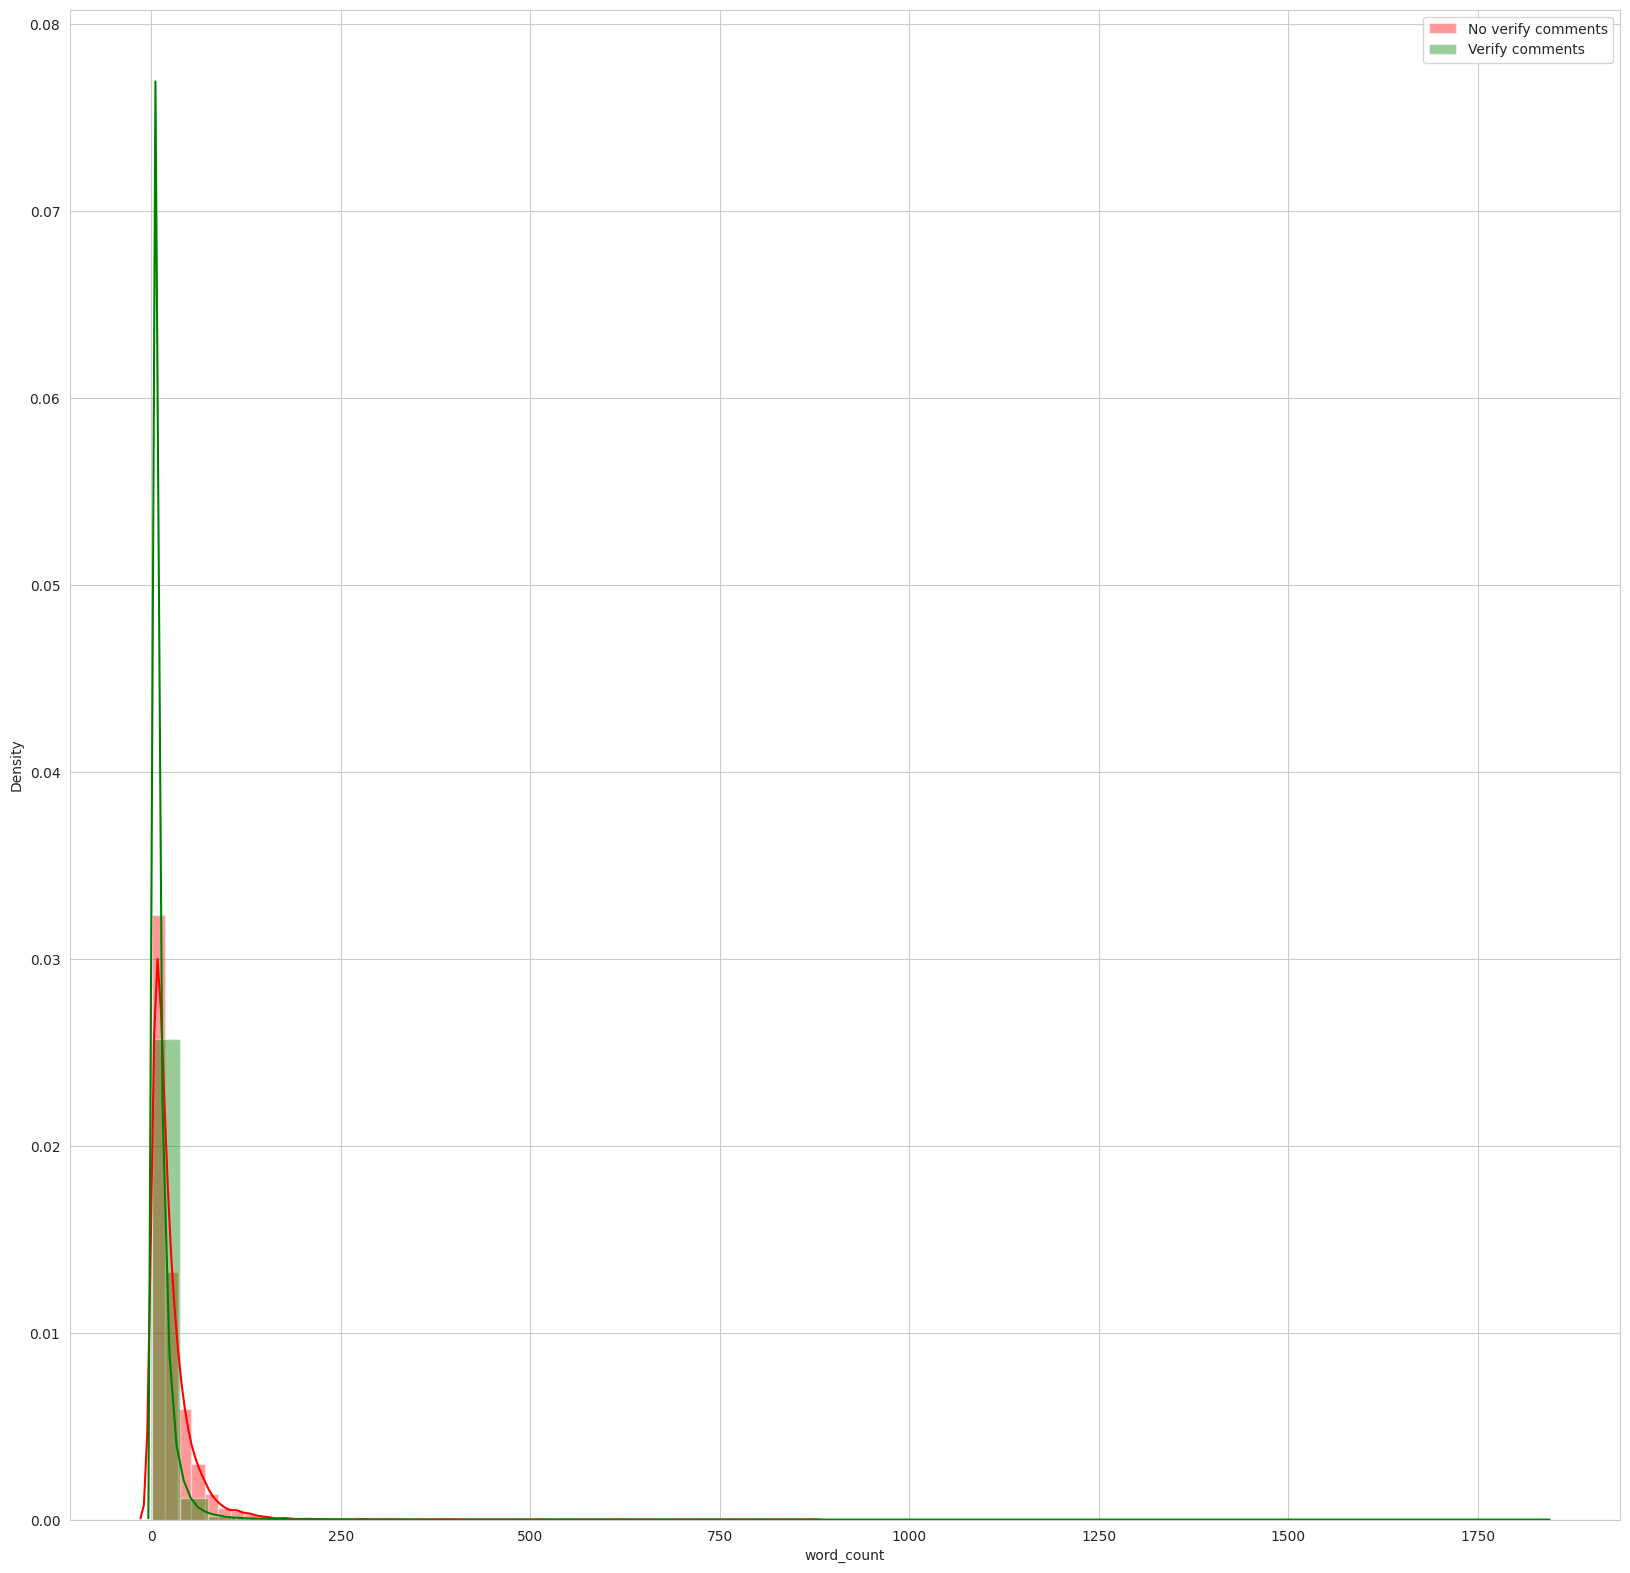

In [17]:
sns.set_style('whitegrid')
plt.subplots(ncols=1, nrows = 1, figsize=(20,20), dpi=100)

sns.distplot(df_train.loc[~verify]['word_count'],label="No verify comments",  color="red")
sns.distplot(df_train.loc[verify]['word_count'], label="Verify comments"  ,color="green")

plt.legend()

## Clean comment

define text processing to process our comment and clean them.
Improving this function cause better cleaning and normalizing our text so it may help better prediction. For example, we ignore bad word.

In [18]:
def textProcess(txt):
    _normalizer = hazm.Normalizer()
    txt = _normalizer.normalize(txt)
    STOPWORDS = hazm.stopwords_list() + ['یه', 'ک', 'ام' , 'باهاش', 'ب', 'داره', '…', ]
    nopunc = [char for char in txt if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    return ' '.join([word for word in nopunc.split() if word not in STOPWORDS])

In [19]:
df_train['clean_comment'] = df_train.comment.apply(textProcess)

In [20]:
df_train

,title,comment,advantages,disadvantages,title_fa_product,title_fa_category,is_buyer,verification_status,rate,word_count,char_count,unique_word_count,clean_comment
0,NaN,مثل بقیه محصولات الکل دار پوست رو خشک نمیکنه,NaN,NaN,4310,325,1,1,100.0,9,44,9,بقیه محصولات الکل پوست خشک نمیکنه
1,Redmi 8,با این مبلغ اگه امکانات و ارزش خرید واستون مهم...,"[""رم4\r"",""قیمت نسبت به سایر برندها\r"",""طراحی و...","[""نداشتن هندزفری""]",5317,655,1,1,80.0,18,88,16,مبلغ اگه امکانات ارزش خرید واستون مهمه گوشی عا...
2,عالی,خوبه فقط کج و کوله بدستم رسید ولی پسرم خیلی خو...,NaN,NaN,2884,63,1,1,100.0,19,86,19,خوبه کج کوله بدستم پسرم خوشحال لطفا بسته توجه بشه
3,NaN,در کل خوب بود ولی متاسفانه درب محصول شکسته بود...,NaN,NaN,3044,326,1,1,70.0,18,85,17,درب محصول شکسته مقداریش داخل بسته خالی
4,NaN,من که خیلی باهاش حال کردم فقط من که همیشه L می...,NaN,NaN,864,128,1,1,72.0,21,96,19,L میپوشیدم اینبار M گرفتم لانگه اندازه ش بزرگتره
...,...,...,...,...,...,...,...,...,...,...,...,...,...
264394,موز,خوبه و راضی کننده,NaN,NaN,3307,479,1,1,90.0,4,17,4,خوبه راضی
264395,کش,رنگ بندی زیبا و قیمت مناسبی دارد,NaN,NaN,4864,61,1,1,60.0,7,32,7,رنگ زیبا قیمت مناسبی
264396,خوب بود,ولی بیشتر آف بذارید,NaN,NaN,3509,489,1,1,0.0,4,19,4,آف بذارید
264397,ارزش خرید داره,کلا بد نیست,NaN,NaN,2099,285,1,1,60.0,3,11,3,کلا بد


From this line we use clean comment feature to train our model. we count 50 of most repeated word to see which word most used in verified and not verified comment

In [21]:
from collections import Counter
verify_count = Counter()
words = df_train[verify].clean_comment.apply(lambda x: [word for word in x.split()])
for word in words:
    verify_count.update(word)
    
print(verify_count.most_common(50))

[('خوبه', 40269), ('کیفیت', 28200), ('قیمت', 26916), ('استفاده', 21803), ('هست', 18852), ('راضی', 16777), ('قیمتش', 16333), ('عالیه', 16118), ('خریدم', 14411), ('میشه', 14288), ('میکنم', 14092), ('واقعا', 12920), ('گوشی', 12433), ('خرید', 11579), ('پیشنهاد', 9972), ('اصلا', 9399), ('کالا', 9349), ('کار', 8950), ('رنگ', 8774), ('دیجی', 8630), ('جنس', 8575), ('نداره', 8533), ('میکنه', 8129), ('شگفت', 7940), ('انگیز', 7744), ('راضیم', 7724), ('بودم', 7455), ('باشه', 6954), ('خوبیه', 6954), ('محصول', 6913), ('ارزش', 6866), ('بد', 6664), ('بسته', 6536), ('گرفتم', 6533), ('دیگه', 6437), ('ازش', 6337), ('سفارش', 6064), ('بوی', 5742), ('توجه', 5661), ('خوش', 5591), ('توی', 5514), ('حتما', 5490), ('بخرید', 5296), ('اگه', 5087), ('جنسش', 5064), ('هستم', 5006), ('مناسبه', 4915), ('ممنون', 4731), ('کیفیتش', 4580), ('اندازه', 4504)]


In [22]:

notverify_count = Counter()
words = df_train[~verify].clean_comment.apply(lambda x: [word for word in x.split()])
for word in words:
    notverify_count.update(word)
    
print(notverify_count.most_common(50))

[('کالا', 2108), ('دیجی', 1847), ('گوشی', 1461), ('قیمت', 1289), ('خرید', 951), ('میشه', 828), ('واقعا', 801), ('هست', 760), ('سفارش', 730), ('استفاده', 725), ('دیگه', 703), ('سلام', 658), ('اصلا', 654), ('خریدم', 599), ('ارسال', 598), ('لطفا', 550), ('تومن', 539), ('محصول', 500), ('روز', 475), ('الان', 459), ('کیفیت', 454), ('دادم', 441), ('اگه', 426), ('باشه', 403), ('نداره', 393), ('میکنم', 382), ('پول', 381), ('قیمتش', 369), ('بسته', 356), ('توی', 355), ('کار', 351), ('جنس', 349), ('دوستان', 347), ('تحویل', 343), ('دستم', 341), ('دلار', 327), ('نکردم', 324), ('ندارم', 323), ('اون', 310), ('میلیون', 302), ('خوبه', 295), ('دیجیکالا', 289), ('میکنه', 285), ('رنگ', 283), ('ساعت', 278), ('دارم', 270), ('موجود', 258), ('دست', 258), ('پایین', 252), ('بشه', 252)]


## Stratified and Modeling

In [23]:
X = df_train.clean_comment
y = df_train.verification_status

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [25]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
X_train_dtm = vec.fit_transform(X_train)
X_test_dtm = vec.transform(X_test)

In [26]:
tfidf = TfidfTransformer()
tfidf.fit_transform(X_train_dtm)

<197049x57763 sparse matrix of type '<class 'numpy.float64'>'
	with 1439102 stored elements in Compressed Sparse Row format>

### Modeling
we train our dataset on just one model. train it with RandomForest, SGDClassifier and check confusion matrix, recall, percision and f1

In [27]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [28]:
nb_pred = nb.predict(X_test_dtm)

In [29]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, nb_pred))

0.9721541342508716


%97 accuracy ??!!

In [30]:
metrics.confusion_matrix(y_test, nb_pred)

array([[  796,  1295],
       [  534, 63058]])

In [31]:
X_test[y_test < nb_pred]

39873                                         استفاده نکردم
29765                    ۳۰هزار تومان می‌ارزه اونم تمیز گاز
22160     کرم سفارش دادم سفید ارسال برام واقعا انگار دیگ...
55854     نمیشه دیجی کالا گرون زده تخفیف گرون‌تر داروخان...
10805                                       😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂
                                ...                        
161727    گوشی هست تلفن همراه هست موبایل هست هست گوشی خر...
228813    الان دستم باکسش اصلا پلمپ نداشت هولوگرامش بود،...
106157    اسباب بازی تاش شکست تیغشم درد پوست کندن خیار ن...
63914                                                مممممم
149642    گوشی رنج قیمت ارزش خرید نداره صبر بازم صبر قیم...
Name: clean_comment, Length: 1295, dtype: object

In [32]:
X_test[y_test > nb_pred]

163582    بهتره سلامتیتون اهمیت بدید پول اب لیمو جه جلو ...
155811    اقا کاری نداریم کی چی دوس کمپانی برنده گوشیشم ...
234109    سلام دوستان الان a۷۱ رم ۸ دارم قیمت گوشی الان ...
259177           کفش خوبیست پرداخت درب منزل رافعال کنیدلطفا
217482    الان کیلویی ۱۳ هزار ۵۰۰ تومن هست ۱۰‌ کیلویی ۱۳...
                                ...                        
108601                           بدلیل عودت کالا نظری ندارم
195475    خرید محصول مشکل آب پاش میخواستم برام تعویض کنن...
168344         لطفا موجود کنید، خواستم سفارش بدم دیدم موجود
98401     قیمت گران جنس موقع سفارش زده ۱۴۹۰۰ موقع واریز ...
54544     لطفا کالاهایی سایت میذارید اونی ارسال میکنید باشه
Name: clean_comment, Length: 534, dtype: object

In [33]:
y_pred_broba = nb.predict_proba(X_test_dtm)[:, 1]
y_pred_broba

array([0.99999228, 0.99997463, 0.99960407, ..., 0.99013149, 0.99999996,
       0.91249175])

In [34]:
metrics.precision_score(y_test, nb_pred)

0.9798766180286855

In [35]:
metrics.recall_score(y_test, nb_pred)

0.9916027173229337

In [36]:
metrics.f1_score(y_test, nb_pred)

0.985704795029114

 #### Test our model

In [37]:
# abuse and offensive comment. we try to cheat our model with "ممنون" word.
test_text = ["دیجی کالا آشغال فروشیه ممنون"]

In [38]:
test_dtm = vec.transform(test_text)

In [39]:
result = nb.predict(test_dtm)

In [40]:
if result == 0:
  print('Not Verify comment')
else:
  print('verify comment')

Not Verify comment


In [42]:
# criticism comment but not abuse.
test_text = ["این مدل گوشی رو من گرفتم ولی راضی نبودم"]
test_dtm = vec.transform(test_text)
result = nb.predict(test_dtm)
if result == 0:
  print('Not Verify comment')
else:
  print('verify comment')

verify comment
